<a href="https://colab.research.google.com/github/wildanputra/deeplearningtutorial/blob/master/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface defect detection

sources inspiration:
https://towardsdatascience.com/deep-learning-computer-vision-and-automated-optical-inspection-774e8ca529d3

dataset : http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html

in this case we will use 2 different method transfer learning for the classification, we will use pre-training & fine tuning with inception v3 model.

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


# Preprocessing
### Download data surface defect

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder_loc = 'gdrive/My Drive/colab notebook/NEU-CLS-64'
base_dir, _ = os.path.splitext(folder_loc)

In [23]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --------- Train --------------
# Directory with our train rs datasets
train_rs_dir = os.path.join(train_dir, 'rs')
print ('Total training rs images:', len(os.listdir(train_rs_dir)))

# Directory with our train pa datasets
train_pa_dir = os.path.join(train_dir, 'pa')
print ('Total training pa images:', len(os.listdir(train_pa_dir)))

# Directory with our train cr datasets
train_cr_dir = os.path.join(train_dir, 'cr')
print ('Total training cr images:', len(os.listdir(train_cr_dir)))

# Directory with our train ps datasets
train_ps_dir = os.path.join(train_dir, 'ps')
print ('Total training ps images:', len(os.listdir(train_ps_dir)))

# Directory with our train in datasets
train_in_dir = os.path.join(train_dir, 'in')
print ('Total training in images:', len(os.listdir(train_in_dir)))

# Directory with our train sc datasets
train_sc_dir = os.path.join(train_dir, 'sc')
print ('Total training sc images:', len(os.listdir(train_sc_dir)))

# Directory with our train sp datasets
train_sp_dir = os.path.join(train_dir, 'sp')
print ('Total training sp images:', len(os.listdir(train_sp_dir)))

# Directory with our train rp datasets
train_rp_dir = os.path.join(train_dir, 'rp')
print ('Total training rp images:', len(os.listdir(train_rp_dir)))

# Directory with our train gg datasets
train_gg_dir = os.path.join(train_dir, 'gg')
print ('Total training gg images:', len(os.listdir(train_gg_dir)))

# --------- Validation --------------

# Directory with our validation rs datasets
validation_rs_dir = os.path.join(validation_dir, 'rs')
print ('Total validation rs images:', len(os.listdir(validation_rs_dir)))

# Directory with our validation pa datasets
validation_pa_dir = os.path.join(validation_dir, 'pa')
print ('Total validation pa images:', len(os.listdir(validation_pa_dir)))

# Directory with our validation cr datasets
validation_cr_dir = os.path.join(validation_dir, 'cr')
print ('Total validation cr images:', len(os.listdir(validation_cr_dir)))

# Directory with our validation ps datasets
validation_ps_dir = os.path.join(validation_dir, 'ps')
print ('Total validation ps images:', len(os.listdir(validation_ps_dir)))

# Directory with our validation in datasets
validation_in_dir = os.path.join(validation_dir, 'in')
print ('Total validation in images:', len(os.listdir(validation_in_dir)))

# Directory with our validation sc datasets
validation_sc_dir = os.path.join(validation_dir, 'sc')
print ('Total validation sc images:', len(os.listdir(validation_sc_dir)))

# Directory with our validation sp datasets
validation_sp_dir = os.path.join(validation_dir, 'sp')
print ('Total validation sp images:', len(os.listdir(validation_sp_dir)))

# Directory with our validation rp datasets
validation_rp_dir = os.path.join(validation_dir, 'rp')
print ('Total validation rp images:', len(os.listdir(validation_rp_dir)))

# Directory with our validation gg datasets
validation_gg_dir = os.path.join(validation_dir, 'gg')
print ('Total validation gg images:', len(os.listdir(validation_gg_dir)))

Total training rs images: 175
Total training pa images: 175
Total training cr images: 175
Total training ps images: 175
Total training in images: 175
Total training sc images: 175
Total training sp images: 175
Total training rp images: 175
Total training gg images: 175
Total validation rs images: 25
Total validation pa images: 25
Total validation cr images: 25
Total validation ps images: 25
Total validation in images: 25
Total validation sc images: 25
Total validation sp images: 25
Total validation rp images: 25
Total validation gg images: 25


### Create Image Data Generator with Image Augmentation
We will use ImageDataGenerator to rescale the images.

To create the train generator, specify where the train dataset directory, image size, batch size and binary classification mode.

The validation generator is created the same way.

In [87]:
image_size = 75 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use categorical loss, we need binary labels
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 1575 images belonging to 9 classes.
Found 225 images belonging to 9 classes.


# Create the base model from inception v3 model

# Fine Tuning

In [26]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model inception V3
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=IMG_SHAPE)

W0722 08:57:55.848747 140643219531648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 1s 0us/step


## Un-freeze the top layers of the model
All we need to do is unfreeze the base_model, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [89]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [61]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Compile the model
Compile the model using a much-lower training rate.

In [0]:
model_fine = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(2048),
  keras.layers.Dense(1024),
  keras.layers.Dense(1024),
  keras.layers.Dense(1024),
  keras.layers.Dense(9, activation='softmax')
  ])

In [0]:
model_fine.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
model_fine.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 18441     
Total params: 26,017,577
Trainable params: 23,841,161
Non-trainable params: 2,176,416
_________________________________________________________________


In [65]:
len(model_fine.trainable_variables)

132

In [93]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history_fine = model_fine.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
49/49 [==============================] - 22s 440ms/step - loss: 1.3880 - acc: 0.7265 - val_loss: 1.8952 - val_acc: 0.3795
Epoch 2/10
49/49 [==============================] - 5s 106ms/step - loss: 0.8211 - acc: 0.8516 - val_loss: 2.4159 - val_acc: 0.3661
Epoch 3/10
49/49 [==============================] - 5s 108ms/step - loss: 0.6638 - acc: 0.8635 - val_loss: 2.6943 - val_acc: 0.3750
Epoch 4/10
49/49 [==============================] - 5s 109ms/step - loss: 0.6413 - acc: 0.8603 - val_loss: 2.9773 - val_acc: 0.3750
Epoch 5/10
49/49 [==============================] - 5s 107ms/step - loss: 0.5670 - acc: 0.8691 - val_loss: 3.3463 - val_acc: 0.3661
Epoch 6/10
49/49 [==============================] - 5s 106ms/step - loss: 0.4815 - acc: 0.8814 - val_loss: 3.3841 - val_acc: 0.3929
Epoch 7/10
49/49 [==============================] - 5s 108ms/step - loss: 0.6039 - acc: 0.8656 - val_loss: 3.4624 - val_acc: 0.4152
Epoch 8/10
49/49 [==============================] - 5s 108ms/step - loss: 0

## Learning curves
Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the Inception V3 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

Note: the training dataset is fairly small, and is similar to the original datasets that Inception V3 was trained on, so fine-tuning may result in **overfitting**.

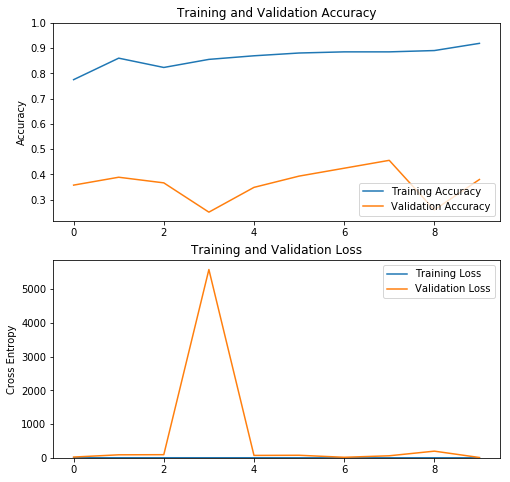

In [86]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# pre-trained inception v3

## Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

### Add a classification head
Now let's add a few layers on top of the base model:

In [0]:
model_pre = tf.keras.Sequential([
  base_model,
  #keras.layers.GlobalAveragePooling2D(),
  #keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  #keras.layers.Dense(2048, activation='relu'),
  #keras.layers.Dropout(0.2),
  #keras.layers.Dense(1024, activation='relu'),
  #keras.layers.Dropout(0.2),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.2),
  #keras.layers.Dense(512, activation='relu'),
  #keras.layers.Dropout(0.5),
  keras.layers.Dense(9, activation='softmax')
  ])

## Compile the model
You must compile the model before training it.

In [0]:
#Case ADAM
model_pre.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#case SGD
model_pre.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01,momentum=0.9,decay=1e-6,nesterov=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
model_pre.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)            

In [104]:
len(model_pre.trainable_variables)

10

### Train the model
After training for 10 epochs, we are able to get ~94% accuracy.

If you have more time, train it to convergence (50 epochs, ~96% accuracy)

In [132]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model_pre.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
49/49 [==============================] - 21s 429ms/step - loss: 0.5267 - acc: 0.8639 - val_loss: 5.4345 - val_acc: 0.3571
Epoch 2/10
49/49 [==============================] - 4s 89ms/step - loss: 0.6760 - acc: 0.8905 - val_loss: 4.9451 - val_acc: 0.3616
Epoch 3/10
49/49 [==============================] - 4s 89ms/step - loss: 1.0319 - acc: 0.8801 - val_loss: 6.1685 - val_acc: 0.3661
Epoch 4/10
49/49 [==============================] - 4s 88ms/step - loss: 0.8605 - acc: 0.8717 - val_loss: 6.3446 - val_acc: 0.3839
Epoch 5/10
49/49 [==============================] - 4s 88ms/step - loss: 0.6816 - acc: 0.8736 - val_loss: 4.6693 - val_acc: 0.3929
Epoch 6/10
49/49 [==============================] - 4s 89ms/step - loss: 0.6294 - acc: 0.8775 - val_loss: 4.1994 - val_acc: 0.4196
Epoch 7/10
49/49 [==============================] - 4s 90ms/step - loss: 0.6878 - acc: 0.8814 - val_loss: 5.2699 - val_acc: 0.4152
Epoch 8/10
49/49 [==============================] - 4s 89ms/step - loss: 0.4100 -

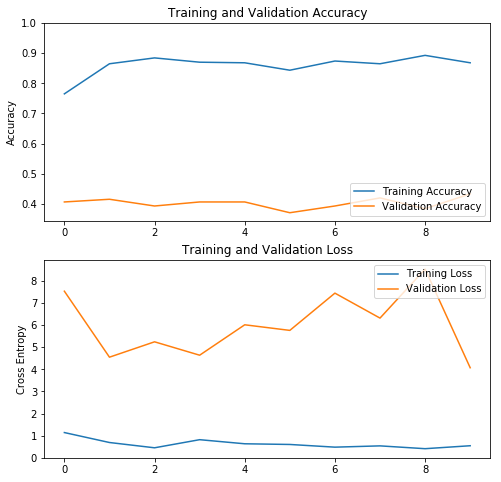

In [127]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()